In [24]:
import sys, os, platform
import tensorflow as tf
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Platform:", platform.platform())
!nvidia-smi

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import json
import random
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
print(os.listdir("/kaggle/input"))

['inceptionv3-weights', 'coco-2017-dataset']


In [4]:
data_root = "/kaggle/input/coco-2017-dataset/coco2017"
print("Inside coco2017:", os.listdir(data_root))


ann_dir = "/kaggle/input/coco-2017-dataset/coco2017/annotations"
print(os.listdir(ann_dir))

Inside coco2017: ['val2017', 'annotations', 'test2017', 'train2017']
['person_keypoints_train2017.json', 'instances_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'captions_val2017.json']


In [5]:
data_root = "/kaggle/input/coco-2017-dataset"

print("Top level:", os.listdir(data_root))

for root, dirs, files in os.walk(data_root):
    print("ROOT:", root)
    print("dirs:", dirs[:5])
    print("files:", files[:5])
    break

Top level: ['coco2017']
ROOT: /kaggle/input/coco-2017-dataset
dirs: ['coco2017']
files: []


In [6]:
data_root = "/kaggle/input/coco-2017-dataset/coco2017"
img_dir = os.path.join(data_root, "train2017")
ann_path = os.path.join(data_root, "annotations", "captions_train2017.json")

# load captions json
with open(ann_path, "r") as f:
    caps_data = json.load(f)

# build id -> filename map
id_to_file = {img["id"]: img["file_name"] for img in caps_data["images"]}

# build filename -> list of captions
file_to_caps = {}
for ann in caps_data["annotations"]:
    img_id = ann["image_id"]
    caption = ann["caption"]
    fname = id_to_file[img_id]
    file_to_caps.setdefault(fname, []).append(caption)

MAX_IMAGES = 5000

all_files = list(file_to_caps.keys())
limited_files = all_files[:MAX_IMAGES]

file_to_caps = {fname: file_to_caps[fname] for fname in limited_files}

print("Using images:", len(file_to_caps))



Using images: 5000


Image file: 000000163289.jpg
Captions:
- A man stares at another man tying a tie.
- Two men are in a bathroom by a mirror.
- A man standing next to a man in a bathroom.
- Two men with ties on standing in front of a mirror. 
- The reflection of two men in the mirrors of a public restroom.


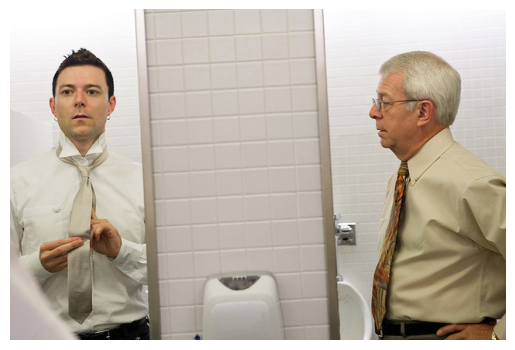

In [7]:
# pick a random image
sample_fname = random.choice(list(file_to_caps.keys()))
sample_path = os.path.join(img_dir, sample_fname)

print("Image file:", sample_fname)
print("Captions:")
for c in file_to_caps[sample_fname][:5]:
    print("-", c)

# show image
img = Image.open(sample_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
import re
from tqdm import tqdm

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9 ]+", "", caption)
    caption = re.sub(r"\s+", " ", caption).strip()
    return caption

clean_file_to_caps = {}

for fname, caps in tqdm(file_to_caps.items()):
    new_caps = []
    for c in caps:
        c_clean = clean_caption(c)
        c_clean = "<start> " + c_clean + " <end>"
        new_caps.append(c_clean)
    clean_file_to_caps[fname] = new_caps

# quick check
some_file = list(clean_file_to_caps.keys())[0]
print(some_file)
print(clean_file_to_caps[some_file][:3])

100%|██████████| 5000/5000 [00:00<00:00, 27017.18it/s]

000000203564.jpg
['<start> a bicycle replica with a clock as the front wheel <end>', '<start> the bike has a clock as a tire <end>', '<start> a black metal bicycle with a clock inside the front wheel <end>']


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

all_captions = []
for caps in clean_file_to_caps.values():
    all_captions.extend(caps)

# fit tokenizer
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

# compute max length
max_len = max(len(c.split()) for c in all_captions)
print("Max caption length:", max_len)

Vocab size: 6711
Max caption length: 48


In [10]:
import numpy as np

word_index = tokenizer.word_index

img_ids = []
input_seqs = []
next_words = []

for fname, caps in clean_file_to_caps.items():
    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq = seq[:i]
            out_word = seq[i]
            # pad input
            in_seq_padded = pad_sequences([in_seq], maxlen=max_len, padding="post")[0]

            img_ids.append(fname)
            input_seqs.append(in_seq_padded)
            next_words.append(out_word)

input_seqs = np.array(input_seqs, dtype="int32")
next_words = np.array(next_words, dtype="int32")

print("Total training pairs:", input_seqs.shape, next_words.shape)

Total training pairs: (285859, 48) (285859,)


In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import os
from tqdm import tqdm
import pickle

# Path to your uploaded weights file
weights_path = "/kaggle/input/inceptionv3-weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load InceptionV3 WITHOUT downloading anything
base_model = InceptionV3(weights=None, include_top=False, pooling="avg")
base_model.load_weights(weights_path)

# Feature extractor (2048-dim)
cnn_model = Model(base_model.input, base_model.output)

def extract_feature(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = cnn_model.predict(x, verbose=0)
    return feat[0]

img_features = {}
for fname in tqdm(file_to_caps.keys()):
    path = os.path.join(img_dir, fname)
    img_features[fname] = extract_feature(path)

print("Total features:", len(img_features))

with open("img_features_inception.pkl", "wb") as f:
    pickle.dump(img_features, f)

2025-12-19 08:20:54.455711: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 5000/5000 [20:22<00:00,  4.09it/s]

Total features: 5000


In [12]:
import pickle

with open("/kaggle/working/img_features_inception.pkl", "rb") as f:
    image_features = pickle.load(f)

print("Total images:", len(image_features))


Total images: 5000


In [13]:
X1 = []  # image features
X2 = []  # input sequences
y  = []  # next words

for fname, caps in clean_file_to_caps.items():
    if fname not in image_features:
        continue

    feature = image_features[fname]

    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq = seq[:i]
            out_word = seq[i]

            in_seq = pad_sequences([in_seq], maxlen=max_len, padding="post")[0]

            X1.append(feature)
            X2.append(in_seq)
            y.append(out_word)

X1 = np.array(X1)
X2 = np.array(X2)
y  = np.array(y)

print(X1.shape, X2.shape, y.shape)


(285859, 2048) (285859, 48) (285859,)


In [14]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model

# Image feature input
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption input
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder = add([fe2, se3])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 48, 256)   │  1,718,016 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 48)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6711)      │  1,724,727 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,558,391 (17.39 MB)

 Trainable params: 4,558,391 (17.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print(model)


<Functional name=functional_1, built=True>


In [16]:
model.fit(
    [X1, X2],
    y,
    epochs=5,
    batch_size=64
)


Epoch 1/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 973s 217ms/step - loss: 4.3043
Epoch 2/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 968s 217ms/step - loss: 3.1513
Epoch 3/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 969s 217ms/step - loss: 2.8503
Epoch 4/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 973s 218ms/step - loss: 2.6845
Epoch 5/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 979s 219ms/step - loss: 2.5579


In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4)
)

model.fit(
    [X1, X2],
    y,
    epochs=5,
    batch_size=64
)


Epoch 1/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 990s 221ms/step - loss: 2.4114
Epoch 2/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 965s 216ms/step - loss: 2.3677
Epoch 3/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 969s 217ms/step - loss: 2.3409
Epoch 4/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 971s 217ms/step - loss: 2.3146
Epoch 5/5
4467/4467 ━━━━━━━━━━━━━━━━━━━━ 968s 217ms/step - loss: 2.2987


In [18]:
model.save("image_caption_model.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved")


Model and tokenizer saved


In [20]:
def generate_caption(model, tokenizer, photo, max_len):
    text = "<start>"

    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([text])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding="post")

        yhat = model.predict([photo.reshape(1,2048), seq], verbose=0)
        yhat = np.argmax(yhat)

        word = tokenizer.index_word.get(yhat)
        if word is None:
            break

        text += " " + word
        if word == "<end>":
            break

    return text


In [21]:
import random

sample_img = random.choice(list(image_features.keys()))

print("Generated Caption:")
print(generate_caption(model, tokenizer, image_features[sample_img], max_len))


Generated Caption:
<start> a large air plane sitting on top of an airport tarmac end of a field end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end end


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []

for fname, caps in list(file_to_caps.items())[:1000]:
    y_pred = generate_caption(
        model,
        tokenizer,
        image_features[fname],
        max_len
    ).split()

    actual.append([c.split() for c in caps])
    predicted.append(y_pred)

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1,0,0,0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))
print("BLEU-4:", corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))


In [28]:
def generate_caption(img_path):
    # 1. Load & preprocess image
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # 2. Extract image feature
    feat = cnn_model.predict(x, verbose=0)
    # feat shape: (1, 2048)

    # 3. Greedy caption generation
    in_text = "<start>"
    result = []

    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding="post")

        yhat = model.predict([feat, seq], verbose=0)
        next_id = np.argmax(yhat)

        word = tokenizer.index_word.get(next_id, "<unk>")
        if word == "<end>":
            break

        result.append(word)
        in_text += " " + word

    return " ".join(result)


In [ ]:
test_image_path = "/kaggle/input/dogggg/images.jpg"

caption = generate_caption(test_image_path)
print("Generated Caption:")
print(caption)
